<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-05/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: CNNs

For this task I have chosen to solve a classification task, classifying apple leaves into either 'healthy', 'rust', or 'powdery' classes, which are indicators for common apple tree afflictions. The data was accessed from this source: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/data.


## Visualization:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


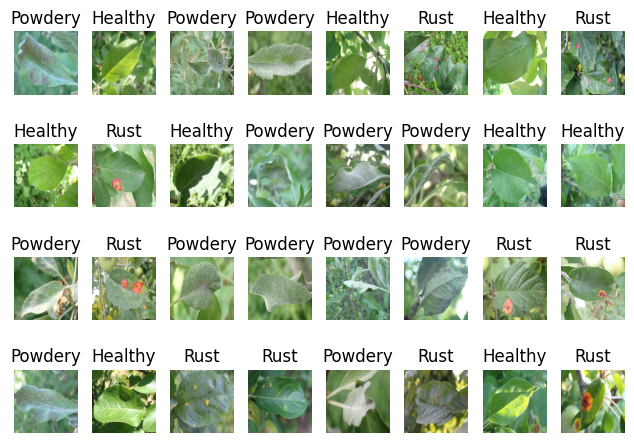

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

from google.colab import drive

drive.mount('/content/drive')

im_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()])

train_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Train/Train', transform = im_transform)
train_loader = torch.utils.data.DataLoader(train_dat, batch_size = 32, shuffle = True)
valid_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Validation/Validation', transform = im_transform)
valid_loader = torch.utils.data.DataLoader(valid_dat, batch_size=len(valid_dat), shuffle = True)
test_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Test/Test', transform = im_transform)
test_loader = torch.utils.data.DataLoader(test_dat, batch_size = len(test_dat))

labs = ['Healthy', 'Powdery', 'Rust']

for i, (x, y) in enumerate(train_loader):
  for j, _ in enumerate(x):
    plt.subplot(4, 8, j+1)
    im = x[j].permute(1, 2, 0)
    plt.imshow(im)
    plt.title(labs[int(y[j])])
    plt.axis('off')
  break
plt.tight_layout()
plt.show()


# Reload data to normalize. Don't apply any augmentation yet.
im_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Train/Train', transform = im_transform)
train_loader = torch.utils.data.DataLoader(train_dat, batch_size = 32, shuffle = True)
valid_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Validation/Validation', transform = im_transform)
valid_loader = torch.utils.data.DataLoader(valid_dat, batch_size=len(valid_dat), shuffle = True)
test_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Test/Test', transform = im_transform)
test_loader = torch.utils.data.DataLoader(test_dat, batch_size = len(test_dat))


## CNN implementation and training:

In [12]:
from torch import nn

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 16, kernel_size=(3,3), stride = 1, padding = 1)
    self.pool = nn.MaxPool2d((2,2))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(16*32*32, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 3)
    self.sm = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    return self.sm(x)




In implementing my CNN, I used 3 convolution and pooling layers, with a relatively small kernel size and dimensionality of 3 and (32/16) respectively. I found that for this dataset, larger dimensionalities made the model train significantly slower, and the validation accuracy increased more gradually. With a larger kernel size, fine details weren't captured as well, which also led to a lower validation accuracy. With the architecture implemented above, very respectable validation accuracies were approached rapidly.


In [15]:
from torch import optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

epochs = 10
lr = 0.001
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

for e in range(epochs):
  model.train()
  losses = []
  for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  print("Epoch: {} | Loss: {:.4f}".format(e,np.mean(losses)))
  best_pred = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in valid_loader:
      pred = torch.argmax(model(x),1)
      print("Validation Accuracy {:.4f}".format(accuracy_score(torch.Tensor.cpu(pred), torch.Tensor.cpu(y))))

      if accuracy_score(torch.Tensor.cpu(pred), torch.Tensor.cpu(y)) >= best_pred:  # Save model based on highest obtained validation accuracy
        best_pred = accuracy_score(torch.Tensor.cpu(pred), torch.Tensor.cpu(y))
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/best_CNN.pt')


model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_CNN.pt', weights_only=False)
model.eval()
with torch.no_grad():
  for (x, y) in test_loader:
    pred = torch.argmax(model(x),1)
    print("Test Accuracy: {:.4f}".format(accuracy_score(pred, y)))

100%|██████████| 42/42 [05:55<00:00,  8.47s/it]


Epoch: 0 | Loss: 1.0186
Validation Accuracy 0.3333


100%|██████████| 42/42 [05:41<00:00,  8.13s/it]


Epoch: 1 | Loss: 0.9873
Validation Accuracy 0.3333


100%|██████████| 42/42 [05:55<00:00,  8.47s/it]


Epoch: 2 | Loss: 0.9280
Validation Accuracy 0.6167


100%|██████████| 42/42 [05:42<00:00,  8.16s/it]


Epoch: 3 | Loss: 0.8859
Validation Accuracy 0.6000


100%|██████████| 42/42 [05:51<00:00,  8.36s/it]


Epoch: 4 | Loss: 0.8768
Validation Accuracy 0.6000


100%|██████████| 42/42 [05:46<00:00,  8.25s/it]


Epoch: 5 | Loss: 0.8302
Validation Accuracy 0.5667


100%|██████████| 42/42 [05:52<00:00,  8.39s/it]


Epoch: 6 | Loss: 0.9341
Validation Accuracy 0.6333


100%|██████████| 42/42 [05:51<00:00,  8.38s/it]


Epoch: 7 | Loss: 0.8002
Validation Accuracy 0.5833


100%|██████████| 42/42 [05:44<00:00,  8.21s/it]


Epoch: 8 | Loss: 0.8449
Validation Accuracy 0.5667


100%|██████████| 42/42 [05:51<00:00,  8.37s/it]


Epoch: 9 | Loss: 0.8194
Validation Accuracy 0.5000
Test Accuracy: 0.4667


In [16]:
import torchvision
import torch
from torch import optim
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm

model = torchvision.models.GoogLeNet()
epochs = 15
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

# Main training loop
for e in range(epochs):
  model.train()
  losses = []
  for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred.logits, y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  print("Epoch: {} | Loss: {:.4f}".format(e,np.mean(losses)))
  best_pred = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in valid_loader:
      pred = torch.argmax(model(x),1)
      print("Validation Accuracy {:.4f}".format(accuracy_score(pred, y)))
      if accuracy_score(pred, y) >= best_pred:  # Save model based on best validation accuracy
        best_pred = accuracy_score(pred, y)
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/best_googlenet.pt')

model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_googlenet.pt', weights_only=False)
model.eval()
with torch.no_grad():
  for (x, y) in test_loader:
    pred = torch.argmax(model(x),1)
    print("Test Accuracy {:.4f}".format(accuracy_score(pred, y)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
100%|██████████| 42/42 [11:45<00:00, 16.80s/it]


Epoch: 0 | Loss: 1.0892
Validation Accuracy 0.6667


100%|██████████| 42/42 [11:38<00:00, 16.63s/it]


Epoch: 1 | Loss: 0.3217
Validation Accuracy 0.6500


100%|██████████| 42/42 [11:40<00:00, 16.69s/it]


Epoch: 2 | Loss: 0.3026
Validation Accuracy 0.8167


100%|██████████| 42/42 [11:34<00:00, 16.54s/it]


Epoch: 3 | Loss: 0.1789
Validation Accuracy 0.9167


100%|██████████| 42/42 [11:21<00:00, 16.23s/it]


Epoch: 4 | Loss: 0.1604
Validation Accuracy 0.9167


100%|██████████| 42/42 [11:37<00:00, 16.62s/it]


Epoch: 5 | Loss: 0.1848
Validation Accuracy 0.7667


100%|██████████| 42/42 [11:28<00:00, 16.39s/it]


Epoch: 6 | Loss: 0.1484
Validation Accuracy 0.8167


100%|██████████| 42/42 [11:28<00:00, 16.39s/it]


Epoch: 7 | Loss: 0.1556
Validation Accuracy 0.8833


100%|██████████| 42/42 [11:30<00:00, 16.43s/it]


Epoch: 8 | Loss: 0.1262
Validation Accuracy 0.9333


100%|██████████| 42/42 [11:26<00:00, 16.34s/it]


Epoch: 9 | Loss: 0.1008
Validation Accuracy 0.9000


100%|██████████| 42/42 [11:32<00:00, 16.50s/it]


Epoch: 10 | Loss: 0.1476
Validation Accuracy 0.8667


100%|██████████| 42/42 [11:37<00:00, 16.61s/it]


Epoch: 11 | Loss: 0.1023
Validation Accuracy 0.9667


100%|██████████| 42/42 [11:32<00:00, 16.49s/it]


Epoch: 12 | Loss: 0.1114
Validation Accuracy 0.9333


100%|██████████| 42/42 [11:26<00:00, 16.36s/it]


Epoch: 13 | Loss: 0.0903
Validation Accuracy 0.9500


100%|██████████| 42/42 [11:36<00:00, 16.58s/it]


Epoch: 14 | Loss: 0.0963
Validation Accuracy 0.9167
Test Accuracy 0.9467


In [21]:
im_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomRotation(180),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomVerticalFlip(),
                                               torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Train/Train', transform = im_transform)
train_loader = torch.utils.data.DataLoader(train_dat, batch_size = 32, shuffle = True)
valid_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Validation/Validation', transform = im_transform)
valid_loader = torch.utils.data.DataLoader(valid_dat, batch_size=len(valid_dat), shuffle = True)
test_dat = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/apple_plant_disease/Test/Test', transform = im_transform)
test_loader = torch.utils.data.DataLoader(test_dat, batch_size = len(test_dat))

In [ ]:
epochs = 10
lr = 0.001
model = CNN()
# model.to(torch.device('cuda'))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

for e in range(epochs):
  model.train()
  losses = []
  for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  print("Epoch: {} | Loss: {:.4f}".format(e,np.mean(losses)))
  best_pred = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in valid_loader:
      pred = torch.argmax(model(x),1)
      print("Validation Accuracy {:.4f}".format(accuracy_score(torch.Tensor.cpu(pred), torch.Tensor.cpu(y))))
      if accuracy_score(torch.Tensor.cpu(pred), torch.Tensor.cpu(y)) >= best_pred:
        best_pred = accuracy_score(torch.Tensor.cpu(pred), torch.Tensor.cpu(y))
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/best_CNN_augmented.pt')

 21%|██▏       | 9/42 [01:14<04:29,  8.17s/it]

In [ ]:
from sklearn.metrics import accuracy_score

model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_CNN_augmented.pt', weights_only=False)
model.eval()
with torch.no_grad():
  for (x, y) in test_loader:
    pred = torch.argmax(model(x),1)
    print("Test Accuracy {:.4f}".format(accuracy_score(pred, y)))